In [1]:
from itertools import islice 
import numpy as np
import pandas as pd
import math
import random
from sklearn.utils import shuffle
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import tikzplotlib
from scipy.stats import norm
eps = np.finfo(float).eps
import pingouin as pt

ModuleNotFoundError: No module named 'tikzplotlib'

In [9]:
#To define linestyles
from collections import OrderedDict
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 5))),
     ('dotted',              (0, (1, 3))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 5))),
     ('dashed',              (0, (5, 3))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 5, 1, 5))),
     ('dashdotted',          (0, (3, 3, 1, 3))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

In [10]:
#To generate output with names.
def name_of_global_obj(xx):
    for objname, oid in globals().items():
        if oid is xx:
            return objname

In [11]:
#Function to count the number of experiments that include person number k
def num_exp_cumu(num_exp):
    num_exp_counts = num_exp.value_counts()
    num_exp_cum = pd.Series(index = range(2,12), dtype = float)

    for j in num_exp_cum.index: 
        sum_ = 0
        for k in range(j,12): 
            sum_ = sum_ + num_exp_counts[k]
        num_exp_cum.loc[j] = sum_
        
    return num_exp_cum

In [12]:
#Read the excel files from the filepath
#The filepath where the results are stored.  
#The res dataframe has person numbers on all even rows, and degrees on all odd rows. 
filepath = "StudentOrderings_small/"
res = pd.read_excel(filepath + "Student_orderings_A_results.xlsx", header = 1)
num_tot_exp = 150

res = pd.concat([res, pd.read_excel(filepath + "Student_orderings_B_results.xlsx", header = 1)], axis = 0 ) 
res = pd.concat([res, pd.read_excel(filepath + "Student_orderings_C_results.xlsx", header = 1)], axis = 0 ) 
res[res == 'x'] = np.NaN
res.index = range(0,2*num_tot_exp)

In [13]:
#Calculate the distance in terms of the minimum degree. (i.e. minimum the difference in degree) 
#In addition, we keep track of the number of cadets that have entered the room (num_exp)
min_diff_degree = pd.Series(index = range(0,num_tot_exp), dtype = float)
num_exp = pd.Series(index = range(0,num_tot_exp), dtype = float)

for j in res.index:
    if j % 2 != 0:
        min_diff_degree[(j-1)/2] = min(np.nanmin(abs(res.loc[j,:].sort_values().diff())), 
                            360 - np.nanmax(res.loc[j,:].sort_values()) + np.nanmin(res.loc[j,:].sort_values()))
        num_exp[(j-1)/2] = res.loc[j,:].count()

In [14]:
#Flag to determine whether the results are realistic. Yes = 0, No = 1. 
#All results with degree difference less than 1 are given flag 1, this would have meant that they sat on top of one another. 
flag = pd.Series(index = range(0,num_tot_exp), dtype = float)
flag[min_diff_degree[min_diff_degree < 1].index] = 1 
flag[min_diff_degree[min_diff_degree > 0].index] = 0

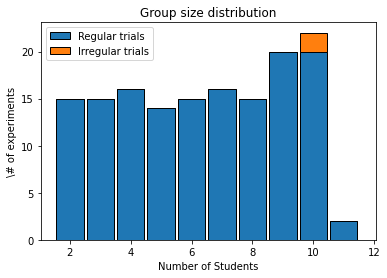

In [18]:
#Figure for group size distribution. Figure #4

x1 = num_exp[flag == 0]
x2 = num_exp[flag == 1]

plt.figure()
plt.hist([x1,x2], label =['Regular trials', 'Irregular trials'], stacked=True, bins= [1.55,2.55,3.55,4.55,5.55,6.55,7.55,8.55,9.55,10.55,11.55],edgecolor='black', width= 0.9)
plt.xlabel('Number of Students')
plt.ylabel('\# of experiments')
plt.legend(loc = 'upper left')
plt.title('Group size distribution');

#Uncomment if you want to save the figure
#tikzplotlib.clean_figure()
#tikzplotlib.save("student_distribution.tex")

In [19]:
#Realized error by the students
min_diff_rad = min_diff_degree * np.pi / 180
error_realized = 1 - (min_diff_rad / 2)/(np.pi/num_exp)

In [20]:
#Error for the split-2 strategy
error_split2 = pd.Series(index = range(0,num_tot_exp), dtype = float) 

for j in error_split2.index: 
    if ((num_exp[j] == 2) | (num_exp[j] == 4) | (num_exp[j] == 8)): 
        error_split2[j] = 0 
    if (num_exp[j] == 3):
        error_split2[j] = 1 - (num_exp[j])/4 
    if ((num_exp[j] > 4) & (num_exp[j] < 8)):
        error_split2[j] = 1 - (num_exp[j])/8
    if (num_exp[j] > 8):
        error_split2[j] = 1 - (num_exp[j])/16

In [22]:
#Error for fixed error finite strategy
def nthHarmonic(N) :
    # H1 = 1
    harmonic = 1
 
    for i in range(2, N + 1) :
        harmonic += 1 / i
 
    return harmonic

def b(k,N):
    return int(pow(2, np.floor(np.log((2*k)/(2*N-1))/np.log(2))))

#k = 6 when the maximum number of students equals 11
for k in range(6,7):
    error_fixed_finite = pd.Series(index = range(0,num_tot_exp), dtype = float)
    pos = pd.Series(index = range(1,2*k+1), dtype = float)
    min_dist = pd.Series(index = range(1,2*k+1), dtype = float)

    for j in pos.index:
        if (j >= 1) & (j <= k):
            pos.loc[j] = ((2*nthHarmonic(b(k,1)) - 2*nthHarmonic((2*j-1)*b(k,j))) / (2*(nthHarmonic(2*k) - nthHarmonic(k)) ))% 1
        elif (j > k) & (j <= 2*k):
            pos.loc[j] = ((2*nthHarmonic(b(k,1)) - nthHarmonic(j) - nthHarmonic(j-1)) / (2*(nthHarmonic(2*k) - nthHarmonic(k)))) %1
        else:
            pos.loc[j] = np.NaN

    for j in min_dist.index: 
        if j == 1: 
            min_dist.loc[1] = 1
        else:
            min_dist.loc[j] = min(pos.loc[:j].sort_values().diff().min(),1 - pos.loc[:j].sort_values().iloc[-1] + pos.loc[:j].sort_values().iloc[0])

    sum_ = 0
    for j in range(k+1, 2*k+1):
        sum_ += 2/(j)
        
for j in error_fixed_finite.index: 
    error_fixed_finite[j] = 1 - num_exp[j]*min_dist[num_exp[j]]

In [23]:
#Error for fixed error strategy
error_fixed = pd.Series(index = range(0,num_tot_exp), dtype = float)

for i in error_fixed.index: 
    for j in range(1,12): 
        if num_exp[i] == j: 
            error_fixed[i] =1-j *np.log(1/(1 - 1/(2*j)))/ np.log(2)

In [24]:
#Error for the split-3 strategy
error_split3 = pd.Series(index = range(0,num_tot_exp), dtype = float) 

for j in error_split3.index: 
    if ((num_exp[j] == 3) | (num_exp[j] == 9) | (num_exp[j] == 27)): 
        error_split3[j] = 0 
    if (num_exp[j] < 3):
        error_split3[j] = 1 - (num_exp[j])/3
    if ((num_exp[j] > 3) & (num_exp[j] < 9)):
        error_split3[j] = 1 - (num_exp[j])/9
    if (num_exp[j] > 9):
        error_split3[j] = 1 - (num_exp[j])/27

In [25]:
#Error for the fixed angle strategy (using Fibonacci)
error_fib = pd.Series(index = range(0,num_tot_exp), dtype = float)
phi = (1+np.sqrt(5))/2

for j in error_fib.index: 
    if num_exp[j] == 2: 
        error_fib[j] = 1 - 2*abs(1/phi -1)
    if ((num_exp[j] == 3)):
        error_fib[j] = 1 - num_exp[j]*abs(2/phi -1)
    if ((num_exp[j] >= 4) & (num_exp[j] < 6)):
        error_fib[j] = 1 - num_exp[j]*abs(3/phi -2)
    if ((num_exp[j] >= 6) & (num_exp[j] < 9)):
        error_fib[j] = 1 - num_exp[j]*abs(5/phi -3)
    if ((num_exp[j] >= 9) & (num_exp[j] < 14)):
        error_fib[j] = 1 - num_exp[j]*abs(8/phi -5)

In [26]:
#Expected error using a random strategy
error_expected_random = pd.Series(index = range(0,num_tot_exp), dtype = float) 
error_expected_random = 1-1/num_exp

In [27]:
#T-test that results in Table 2

# Python paired sample t-test:
for y in [error_realized]:
    for x in [error_split2, error_fixed_finite, error_fixed,error_split3, error_fib , error_expected_random]:
        test_flag = pt.ttest(x[flag==0], y[flag==0], paired = True, alternative = 'greater')
        test_flag_rev = pt.ttest(y[flag==0], x[flag==0], paired = True, alternative = 'greater')
        print('{} & {} & {} & {} & {} & {} & {}'.format(name_of_global_obj(x), x[flag == 0].mean(),x[flag == 0].var(), test_flag_rev['p-val'][0], test_flag_rev.power[0] ,test_flag['p-val'][0], test_flag.power[0])) 

    print('Statistics for error_realized', y.mean(), y[flag == 0].mean(), y[flag == 0].var())

error_split2 & 0.21368243243243243 & 0.028380820233498808 & 1.54643399353521e-08 & 0.9999999985617323 & 0.9999999845356601 & 1.4382677271385091e-09
error_fixed_finite & 0.2254824548964936 & 0.0003457803125493417 & 1.2674832448052335e-07 & 0.9999999999998429 & 0.9999998732516755 & 1.5709655798445965e-13
error_fixed & 0.2376864665153675 & 0.0007411338516639744 & 4.836771626755188e-06 & 0.9999999986345549 & 0.9999951632283732 & 1.3654450903288762e-09
error_split3 & 0.2980480480480481 & 0.05099398970651175 & 0.5699307067653887 & 0.029415082100364476 & 0.43006929323461124 & 0.0807195500432284
error_fib & 0.371150068140507 & 0.008258095471454662 & 0.9999999936036066 & 3.603783937933258e-13 & 6.396393358534565e-09 & 0.9999999999996396
error_expected_random & 0.7948327385827387 & 0.014883182912524247 & 1.0 & 0.0 & 6.3530229496663125e-83 & 1.0
Statistics for error_realized 0.3035 0.2940878378378378 0.02588291345483806


In [45]:
#This function returns how much degrees a person differs from the middle of a gap. 
def diff_from_mid():
    #positive if the person is seated along the cirkel at a higher degree than the middle (clockwise) 
    #negative otherwise
    in_middle_hist = pd.DataFrame(index = range(0,num_tot_exp), dtype = float)

    for k in res.index: 
        if k % 2 != 0: 
            for j in range(2,int(num_exp.loc[(k-1)/2])+1):   
                #Sort the results by the degree and add a column that gives the index of a person           
                sort = res.loc[k].dropna().reset_index().drop('index', axis = 1).iloc[:j].sort_values(by = k)
                sort.index = sort.index + 1 
                sort.reset_index(inplace = True)
                idx = sort[sort == j].dropna(how = 'all', subset = ['index']).index[0] 
                #if the idx = 0 or idx = j-1, then the middle is somewhere 'around' 0 / 360 degrees, so we then need a 
                #different calculation
                if ((idx > 0) & (idx < j-1)):
                    middle = (sort.loc[idx - 1,k] + (sort.loc[idx + 1,k] - sort.loc[idx - 1,k])/2) 
                    in_middle_hist.loc[(k-1)/2,j] = (sort.loc[idx,k] - middle)
                else:  
                    if idx == 0: 
                        middle = sort.loc[1,k] - (360 - sort.loc[j-1,k] + sort.loc[1,k])/2
                        if middle <0: 
                            in_middle_hist.loc[(k-1)/2,j] = - middle + sort.loc[0,k]               
                        else: 
                            in_middle_hist.loc[(k-1)/2,j] = sort.loc[0,k] - middle
                    if idx == j-1:
                        middle = sort.loc[j-2,k] + (360 - sort.loc[j-2,k] + sort.loc[0,k])/2
                        if  middle > 360: 
                            in_middle_hist.loc[(k-1)/2,j] =  middle - sort.loc[j-1,k]
                        else: 
                            in_middle_hist.loc[(k-1)/2,j] = sort.loc[j-1,k] - middle

    return in_middle_hist

In [48]:
#This function returns how big the gap is, in degrees, in which a person is seated.  
def in_gap():
    in_gap = pd.DataFrame(index = range(0,num_tot_exp), dtype = float)

    for k in res.index:
        if k % 2 != 0:
            for j in range(2,int(num_exp.loc[(k-1)/2])+1):
                #Sort the results by the degree and add a column that gives the index of a person 
                sort = res.loc[k].dropna().reset_index().drop('index', axis = 1).iloc[:j].sort_values(by = k)
                sort.index = sort.index + 1 
                sort.reset_index(inplace = True)
                idx = sort[sort == j].dropna(how = 'all', subset = ['index']).index[0] 
                #if the idx = 0 or idx = j-1, then the middle is somewhere 'around' 0 / 360 degrees, so we then need a 
                #different calculation
                if ((idx > 0) & (idx < j-1)):
                    in_gap.loc[(k-1)/2,j] = (sort.loc[idx + 1,k] - sort.loc[idx - 1,k])
                else:  
                    if idx == 0: 
                        in_gap.loc[(k-1)/2,j] = (360 - sort.loc[j-1,k] + sort.loc[1,k])
                    if idx == j-1:
                        in_gap.loc[(k-1)/2,j] = (360 - sort.loc[j-2,k] + sort.loc[0,k])
    
    return in_gap

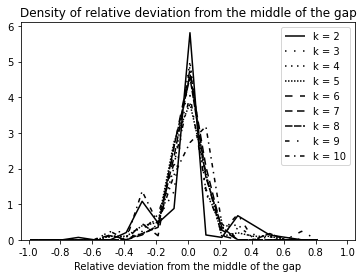

In [49]:
#A Figure to show the density of the relative deviation from the middle of the gap, see Figure 5
diff = diff_from_mid().div(in_gap()/2)
plt.figure()
diff = diff[flag == 0]
for k in range(2,11):
    n,x,_ = plt.hist(diff.loc[:,k], bins = [x/750 -0.0375 for x in list(range(-750,750,75))],edgecolor='none',histtype=u'step',density = True)
    bin_centers = 0.5*(x[1:]+x[:-1])
    plt.plot(bin_centers,n,label = 'k = {}'.format(k), color='k', linestyle=linestyles[list(linestyles)[k-2]]) 
    plt.xlabel('Relative deviation from the middle of the gap')
    plt.legend()
    plt.title('Density of relative deviation from the middle of the gap')
        
    plt.xticks([yy/5 for yy in range(-5,6)], [yy/5 for yy in range(-5,6)])
    plt.xlim([-1.05,1.05])
    
#tikzplotlib.save("middle.tex")

In [52]:
#This function returns the size of the largest gap, for each entering person. 
def the_largest_gap():
    the_largest_gap = pd.DataFrame(index = range(0,num_tot_exp), dtype = float)

    for k in res.index:
        if k % 2 != 0:
            the_largest_gap.loc[(k-1)/2, 2] = 360
            for j in range(2,int(num_exp.loc[(k-1)/2])):  
                max_ = res.loc[k].dropna().iloc[:j].sort_values().diff().max()
                max_new = max(max_,360 - res.loc[k].dropna().iloc[:j].sort_values().iloc[-1] + res.loc[k].dropna().iloc[:j].sort_values().iloc[0])
                the_largest_gap.loc[(k-1)/2,j+1] = max_new
                      
    return the_largest_gap

In [112]:
#This function returns the percentage of the table that contains the largest gap. 
#E.g. when person 3 enters, and person 1 and person 2 are seated at 90 and 270 degrees, then the perc_largest_gap = 1.
#The input parameter gap_var gives the possibility to deviate a little bit from the largest gap. 
#E.g. if gap_var = 0.05, we say that we are 'in the largest gap' if the gap the cadet is seated in, is not more than 5% smaller than the largest gap
#In the paper only gap_var = 0 is used
def percentage_largest_gaps(gap_var): 
    perc_largest_gaps = pd.DataFrame(index = range(0,num_tot_exp), dtype = float)
    
    for k in res.index:
        if k % 2 != 0:
            #Person number 2 always sits in the largest gap
            perc_largest_gaps.loc[(k-1)/2, 2] = 1
            for j in range(2,int(num_exp.loc[(k-1)/2])): 
                #calculate the largest gap for all gaps that are not around 0 / 360 degrees
                max_ = res.loc[k].dropna().iloc[:j].sort_values().diff().max()
                #see if the largest gap is around 0 / 360 degrees
                max_rev = 360 - res.loc[k].dropna().iloc[:j].sort_values().iloc[-1] + res.loc[k].dropna().iloc[:j].sort_values().iloc[0]
                max_new = max(max_,max_rev)
                gap_var_abs = gap_var * max_new
                #count how many gaps satisfy the condition on gap_var (note that the middle term is always non-positive)
                count = res.loc[k].dropna().iloc[:j].sort_values().diff() -max_new >= - gap_var_abs
                count_rev = 360 - res.loc[k].dropna().iloc[:j].sort_values().iloc[-1] + res.loc[k].dropna().iloc[:j].sort_values().iloc[0] - max_new >= -gap_var_abs
                idx = (count[count == True]).index
                perc_largest_gaps.loc[(k-1)/2,j+1] = (res.loc[k].dropna().iloc[:j].sort_values().diff()[idx].sum() + (count_rev == True)*max_rev)/360
                
    return perc_largest_gaps

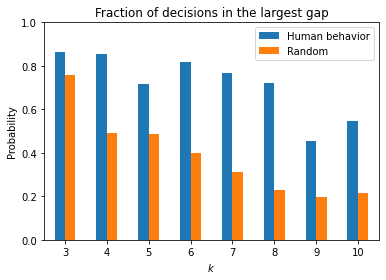

In [117]:
#The perentage of the table where that contains a largest gap is, see Figure 6 
perc_largest_gaps = pd.Series(percentage_largest_gaps(0)[flag == 0].mean(axis = 0), name = 'Random')

#The percentage of humans that are seated in the largest gap. 
largest = the_largest_gap() 
in_largest_gap = (largest <= in_gap())
perc_in_largest_gap = pd.Series(in_largest_gap[flag == 0].sum(axis = 0).div(num_exp_cumu(num_exp[flag == 0])), name = 'Human behavior')

#Join both dataframes
tot = pd.DataFrame(perc_in_largest_gap)
result = tot.join(perc_largest_gaps)

result.loc[3:10,:].plot.bar()
plt.title("Fraction of decisions in the largest gap")
plt.xticks(rotation = 0)
plt.yticks([yy/5 for yy in range(0,6)], [yy/5 for yy in range(0,6)])
plt.xlabel("$k$")
plt.ylabel("Probability") ;   
#tikzplotlib.save("Fraction_largest_gap.tex")

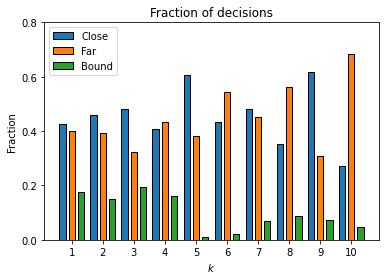

In [121]:
#To find where cadets are seated, at which angle, we use the following. See Figure 7. 
#Get only the degrees from the res-dataframe
degree = pd.DataFrame(index = range(0,num_tot_exp), columns = list(range(1,12)), dtype = float)

for j in res.index: 
    if j%2 !=0:
        deg = res.loc[j].dropna()
        deg.index = range(1,int(num_exp[(j-1)/2])+1)
        degree.loc[int((j-1)/2),1:int(num_exp[(j-1)/2])+1] = deg
        
#Determine the fractions of people that seat at a specific point
fracs = pd.DataFrame(index = ['Close', 'Far', 'Bound'], columns = list(range(1,12)), dtype = float)

tot = num_exp_cumu(num_exp[flag == 0])
tot.loc[1] = tot.loc[2]
deg_far =  degree > 270 
deg_far2 = degree < 90 
deg_c = degree[degree < 270 ]
deg_close = deg_c > 90

fracs.loc['Bound'] = (tot - deg_far[flag == 0].sum() - deg_far2[flag == 0].sum() - deg_close[flag == 0].sum()).div(tot) 
fracs.loc['Far'] = (deg_far[flag == 0].sum() + deg_far2[flag == 0].sum()).div(tot)  
fracs.loc['Close'] = deg_close[flag == 0].sum().div(tot)

#Make figure 
width = 0.2 # width of each bar
ind = np.arange(10) + width/2   # index / x-axis value

DistBetweenBars = 0.1 # distance between bars
Num = 3 # number of bars in a group
# calculate the width of the grouped bars (including the distance between the individual bars)
WithGroupedBars = Num*width + (Num-1)*DistBetweenBars
DistBetweenGroups = 1 - width*Num - (Num-1)*DistBetweenBars 
if DistBetweenGroups < 0: 
    print('Error')

fig, ax = plt.subplots()
for i in range(Num):
    ax.bar(ind-(WithGroupedBars)/2 + (width+DistBetweenBars)*(i),fracs.iloc[i,0:10].transpose().to_list(), width,  edgecolor = 'black')

#.plot.bar(align='center', width=0.9)
plt.title("Fraction of decisions")
plt.xticks([xx   for xx in range(0,10)], [xx +1 for xx in range(0,10)], rotation = 0)
plt.yticks([yy/5 for yy in range(0,5)], [yy/5 for yy in range(0,5)])
plt.xlabel("$k$")
plt.ylabel("Fraction")    
plt.legend(fracs.index);

#plt.show()
#tikzplotlib.save("Fraction_close.tex")

In [126]:
#Wilcoxon-test that results in Table 3

for x in [error_split2, error_fixed_finite, error_fixed, error_split3, error_fib, error_expected_random]:   
    num_plus = (error_realized[flag == 0] <= x[flag == 0]).sum()
    num_min = (error_realized[flag == 0] > x[flag == 0]).sum()
    print(name_of_global_obj(x), num_plus / (num_plus + num_min), stats.wilcoxon(x[flag == 0], error_realized[flag == 0],alternative='less')[1],stats.wilcoxon(x[flag == 0],error_realized[flag == 0], alternative='greater')[1])


error_split2 0.38513513513513514 2.1035882786877882e-07 0.9999997896411721
error_fixed_finite 0.2972972972972973 4.077016421928972e-07 0.9999995922983578
error_fixed 0.34459459459459457 1.539170568235593e-05 0.9999846082943177
error_split3 0.581081081081081 0.6284124842681305 0.37158751573186954
error_fib 0.6959459459459459 0.999999997279612 2.720388024304782e-09
error_expected_random 0.9932432432432432 1.0 2.635931006957763e-26


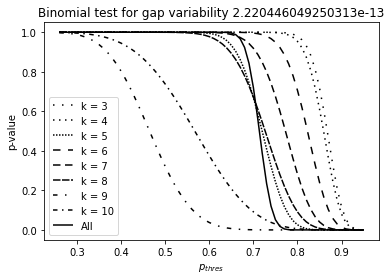

In [128]:
#Figure 9
largest = the_largest_gap()
#The relative deviation from the largest gap
gaps = (largest - in_gap()).div(largest)
#In the paper we have gap_var = eps, but one can also consider a small deviation from the largest gap by adjusting gap_var
for gap_var in [eps*pow(10,3)]:
    benchmark = percentage_largest_gaps(gap_var)[flag==0]
    in_largest_gap = (gaps <= gap_var)
    in_largest_gap = in_largest_gap[flag == 0]
    num_exp_cum = num_exp_cumu(num_exp[flag == 0])
    color_grey = 0
    x_start = 25
    x_end = 95
    plt.figure()
    #The plots for all k
    for k in range(3,11):
        x_alldata = pd.Series(index = range(x_start,x_end), dtype = float)
        for prob in range(x_start,x_end):
            stat_test_alldata = stats.binomtest(int(in_largest_gap.sum()[(k-2):(k-1)].sum()), 
                                                int(num_exp_cum[(k-2):(k-1)].sum()), (prob+1)/100, alternative='less') 
            x_alldata.loc[prob] = stat_test_alldata.pvalue
        x_alldata.index = (x_alldata.index + 1)/100
        x_alldata.plot(label = 'k = {}'.format(k), linestyle=linestyles[list(linestyles)[k-2]], color = (color_grey, color_grey, color_grey))
            
    #The plot for 'All'
    x_alldata = pd.Series(index = range(x_start,x_end), dtype = float)
    for prob in range(x_start,x_end):
        stat_test_alldata = stats.binomtest(int(in_largest_gap.sum()[3:(11)].sum()), 
                                            int(num_exp_cum[3:(11)].sum()), (prob+1)/100, alternative='less') 
        x_alldata.loc[prob] = stat_test_alldata.pvalue
        
    x_alldata.index = (x_alldata.index + 1)/100
    x_alldata.plot(label = 'All', linestyle =linestyles[list(linestyles)[0]], color = (color_grey, color_grey, color_grey))

    plt.title("Binomial test for gap variability {}".format(gap_var))
    plt.yticks([yy/5 for yy in range(0,6)], [yy/5 for yy in range(0,6)])
    plt.legend()
    plt.xlabel("$p_{thres}$")
    plt.ylabel("p-value");
    
    #tikzplotlib.save("Largest_gap_{}_relative.tex".format(gap_var))


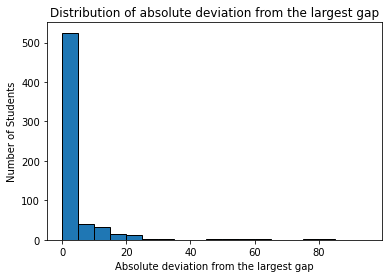

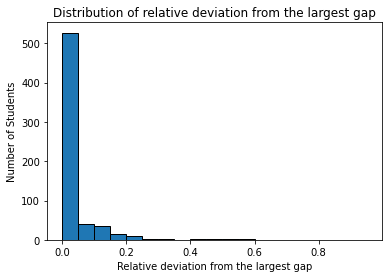

In [131]:
#Figure 10
plt.figure()
(the_largest_gap().loc[:,3:11] - in_gap().loc[:,3:11])[flag == 0].stack().plot.hist(label = 'All', bins = [x/10 for x in list(range(0,1000,50))],edgecolor='black')
plt.xlabel('Absolute deviation from the largest gap')
plt.ylabel('Number of Students')
plt.title('Distribution of absolute deviation from the largest gap');

#tikzplotlib.save("distribution_gap_absolute.tex")

plt.figure()
(the_largest_gap().loc[:,3:11] - in_gap().loc[:,3:11]).div(the_largest_gap().loc[:,3:11])[flag == 0].stack().plot.hist(label = 'All', bins = [x/1000 for x in list(range(0,1000,50))],edgecolor='black')
plt.xlabel('Relative deviation from the largest gap')
plt.ylabel('Number of Students')
plt.title('Distribution of relative deviation from the largest gap');

#tikzplotlib.save("distribution_gap_relative.tex")